<a href="https://colab.research.google.com/github/paul028/EE298-HW1_CIFAR10/blob/master/CIFAR10_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from tensorflow.keras.models import Sequential
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Input
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.misc import toimage
import numpy as np
import os
import tensorflow as tf

Using TensorFlow backend.


In [0]:

class TrainingPlot(tf.keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

In [0]:
# This address identifies the TPU we'll use when configuring TensorFlow.
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.reshape(50000, 32 * 32 * 3)
x_test = x_test.reshape(10000, 32 * 32 * 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0
nb_epoch = 125
batch_size = 128

nb_classes = len(np.unique(y_train))
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)


In [0]:
batch_size = 64
weight_decay = 1e-4
nb_epoch=125

In [6]:
# MLP
model = Sequential()
model.add(Dense(1024, input_shape=(3072, )))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              3146752   
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
activation_1 (Activat

In [0]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 40:
        lrate = 0.0005
    if epoch > 60:
        lrate = 0.0003
    if epoch > 80:
        lrate = 0.0001
    if epoch > 100:
        lrate = 0.00003  
    return lrate

In [8]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
model,
strategy=tf.contrib.tpu.TPUDistributionStrategy(
    tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.45.154.154:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 114515757806740206)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 1539937145629857360)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 10048734782921728532)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1

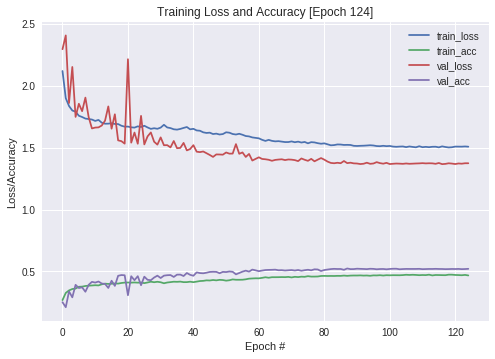

50000/50000 [==============================] - 13s 253us/sample - loss: 1.5078 - acc: 0.4678 - val_loss: 1.3741 - val_acc: 0.5213


In [9]:
history = tpu_model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=125,
                        verbose=1,
                        validation_data=(x_test, y_test),callbacks=[LearningRateScheduler(lr_schedule),plot_losses])

In [10]:

scores = tpu_model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print("\nTest result: %.3f loss: %.3f" % (scores[1]*100,scores[0]))


INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(16,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(16, 3072), dtype=tf.float32, name='dense_input_10'), TensorSpec(shape=(16, 10), dtype=tf.float32, name='activation_3_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for dense_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f6f885cee48> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 2.035693407058716 secs
10000/10000 [==============================] - 4s 378us/sample - loss: 1.3720 - acc: 0.5203

Test result: 52.030 loss: 1.372
